# **--- CNN MODEL ---** #

## **I. Libraries import** ##


In [199]:
# Torch ------------------
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models,datasets
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim

# Visualization ---------
import plotly.graph_objects as go
import matplotlib.pyplot as plt


from PIL import Image
from pathlib import Path


We select the appropriate torch device

In [200]:
#device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # Apple M1/M2/M3
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using {device} device")

Using mps device


## **II. Images import** ##


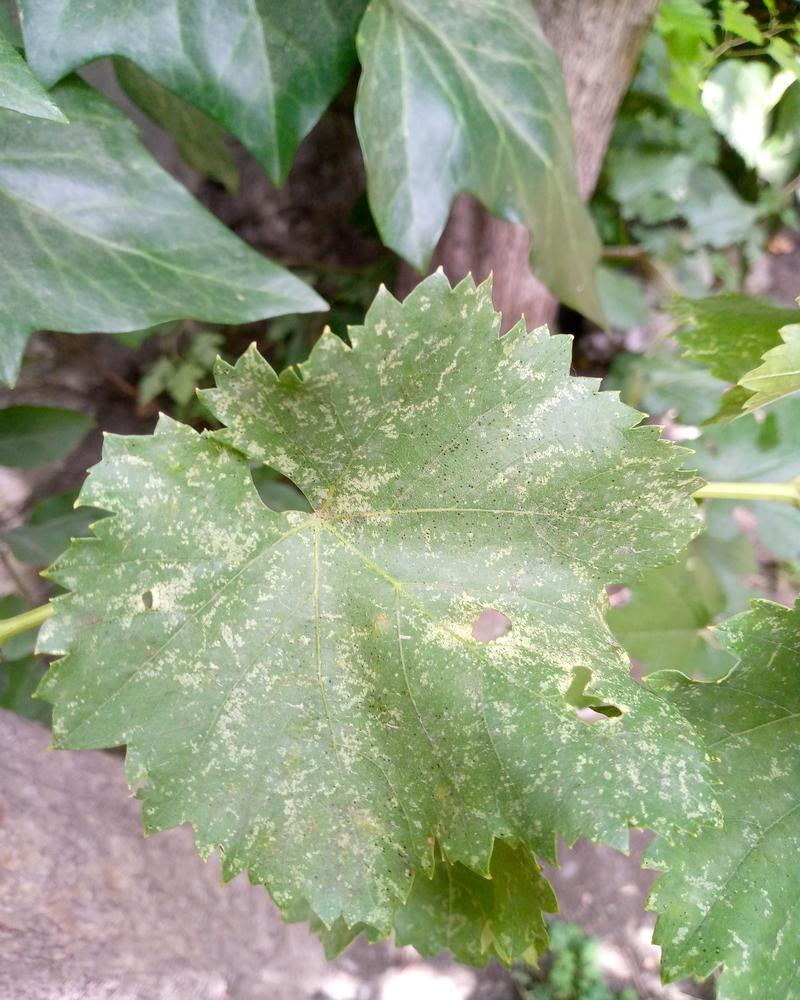

In [201]:
img = Image.open("../data/train/train/Grape Anthracnose leaf/1.jpg")
#img.show()
display(img)

## **III. Images processing** ##


### Pipeline for data transformation ###


The dataset already contains pictures that have been flipped horizontaly, verticaly and randomly rotated. We need to resize the pictures to the size required by the Resnet Model (224,224).

In [202]:
# Définir les transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionnement à 224x224
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.ToTensor(),          # Conversion en tenseur
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225])  # Normalisation avec les valeurs du modèle pré-entraîné Resnet
])

### Load dataset ###


Our dataset is already divided into a train and a test set. We are going to extract 20% of the training set to create the validation set.

In [203]:
# Create the path to the training dataset
data_root = Path("../data/train/train")

# Load dataset with ImageFolder
dataset = ImageFolder(root=data_root, transform=transform)

# Get class names
class_names = dataset.classes

# Define the set size
train_size = int(0.8 * len(dataset))
val_size = len(dataset)-train_size

# We split our initial train dataset into the final train dataset (80%) and the validation dataset (20%)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [204]:
class_names

['Grape Anthracnose leaf',
 'Grape Brown spot leaf',
 'Grape Downy mildew leaf',
 'Grape Mites_leaf disease',
 'Grape Normal_leaf',
 'Grape Powdery_mildew leaf',
 'Grape shot hole leaf disease']

In [205]:
nb_classes = len(dataset.classes)
nb_classes

7

In [206]:
print(f"- Train dataset size : {train_size} \n- Validation dataset size :  {val_size}")

- Train dataset size : 5044 
- Validation dataset size :  1261


In [207]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

###---------------------------------
Si on a le temps :  on peut faire une classe maladie avec toutes les maladies regroupées pour faire un test sain/malade (dans ce cas là on pourra faire une classe personnalisée avec Pytorch dataset et créer le dataset en utilisant cette classe)
---------------------------------------###

Visualisation of a batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Label : Grape Powdery_mildew leaf


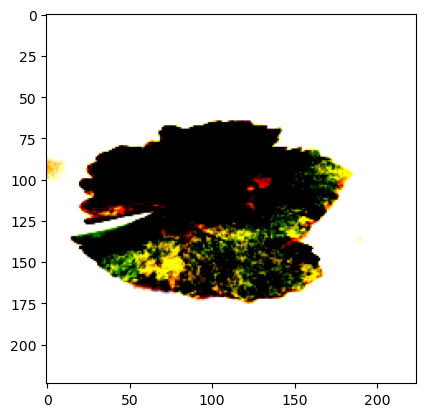

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2959158..1.8208281].


Label : Grape Powdery_mildew leaf


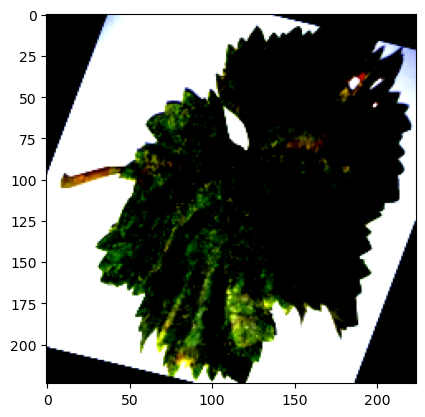

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Label : Grape Normal_leaf


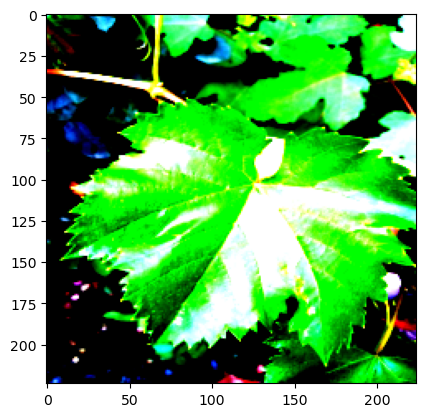

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9876702..2.1171243].


Label : Grape Powdery_mildew leaf


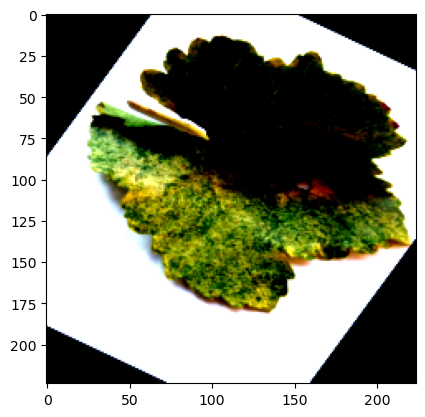

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Label : Grape Normal_leaf


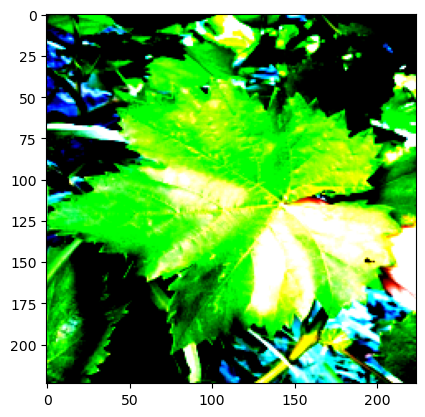

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..0.5484969].


Label : Grape Mites_leaf disease


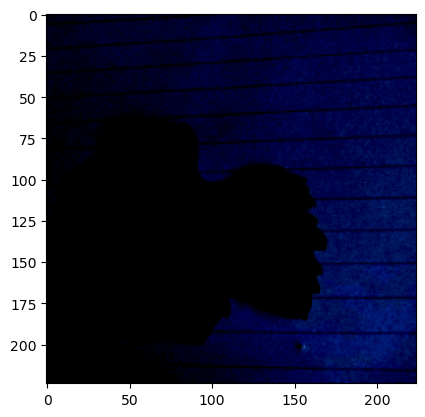

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.4308496].


Label : Grape Powdery_mildew leaf


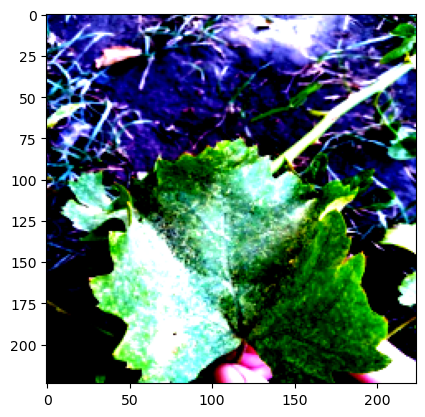

Label : Grape Normal_leaf


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5870366..2.64].


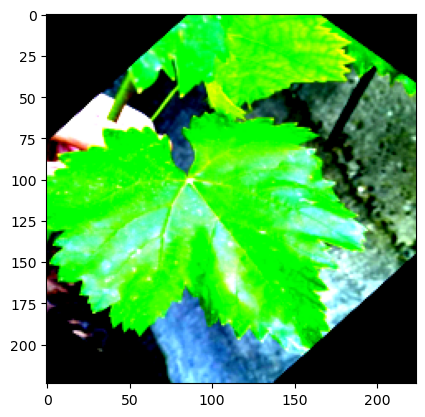

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2445416..1.8905448].


Label : Grape Brown spot leaf


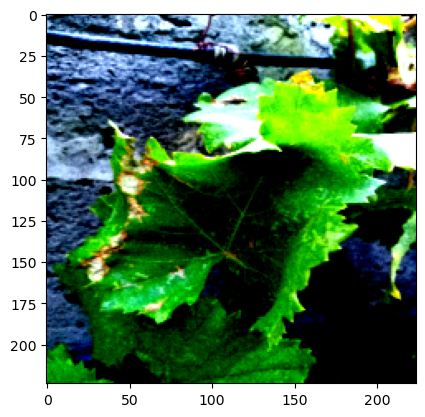

Label : Grape Mites_leaf disease


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..1.9776908].


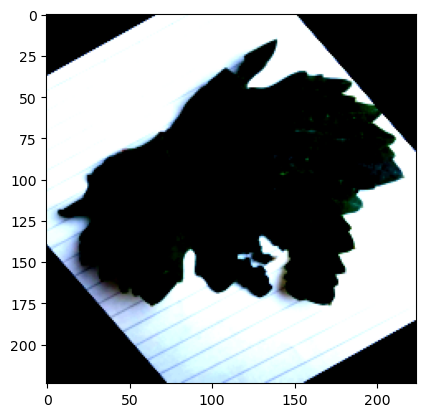

In [208]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

imgs, labels = next(iter(train_loader))
for i, (img, label) in enumerate(zip(imgs, labels)):
  true_label_name = class_names[label]
  print("Label :", true_label_name)
  plt.imshow(img.permute(1, 2, 0).numpy())
  plt.show()
  if i==9: break

## **Transfert learning (Resnet18)** ##

### Importing a pre-trained model

In [218]:
model = models.resnet18(pretrained=True)
model=model.to(device)
print(f"Model device: {next(model.parameters()).device}")
print(device)

/opt/anaconda3/envs/vitiscan_cnn/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/vitiscan_cnn/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model device: mps:0
mps


In [210]:
summary(model, input_size=(1, 3, 224, 224))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

### Replace classifier to adapt the model to our features ###

In [ ]:
model.fc = nn.Linear(model.fc.in_features, nb_classes)


### Freeze the feature extraction layers ###

In [ ]:
# We freeze all the convolutional layers
for param in model.parameters():
    param.requires_grad = False

# We unfreeze the last layer
for param in model.fc.parameters():
    param.requires_grad = True



In [213]:
# Print model summary
summary(model, input_size=(1, 3, 224, 224))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 7]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

### Adapting the model to the dataset ###

In [214]:
train_dataset.dataset.classes

['Grape Anthracnose leaf',
 'Grape Brown spot leaf',
 'Grape Downy mildew leaf',
 'Grape Mites_leaf disease',
 'Grape Normal_leaf',
 'Grape Powdery_mildew leaf',
 'Grape shot hole leaf disease']

### Defining the cost function and optimizer ###

In [215]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)  # Move loss function to MPS

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

### Train the model ###

In [ ]:
# Model outputs
image, label = next(iter(train_loader))
image=image.to(device)
logit= model(image) # Resnet18 output
logit
# Attention il faut que l'image et le model aient le même device

tensor([3, 2, 4, 3, 3, 5, 2, 4, 5, 2, 4, 0, 6, 0, 4, 4, 4, 3, 1, 5, 5, 5, 6, 4,
        2, 5, 4, 0, 3, 5, 3, 0])


tensor([[-1.4535, -1.8618,  1.4520,  ..., -0.4184, -0.3272,  2.6965],
        [-2.4125, -0.3668, -2.3103,  ...,  5.6651, -0.1380,  1.8257],
        [-3.6974,  0.4593,  0.2144,  ..., -3.2495,  3.3749,  1.0960],
        ...,
        [-0.8007,  0.8222, -4.5454,  ...,  0.4048,  1.1589, -0.5728],
        [-0.1205, -3.5285, -1.1702,  ..., -0.5686,  0.1828,  3.0407],
        [ 1.2724,  1.5526,  0.9966,  ..., -2.6991,  1.9396,  5.2089]],
       device='mps:0', grad_fn=<LinearBackward0>)

In [227]:
# Training function for a PyTorch model
def train(model, train_loader, val_loader, criterion, optimizer, epochs=1):

    # Dictionary to store loss and accuracy values for each epoch
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    # Loop through the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss, correct = 0, 0  # Initialize loss and correct predictions

        # Training loop - iterate through batches in the training set
        for images, labels in train_loader:
            images,labels = images.to(device),labels.to(device)
            optimizer.zero_grad()  # Reset gradients before each batch
            logit = model(images)  # Forward pass: Get predictions
            probabilities = torch.softmax(logit, dim=1)  # [batch_size, 7]
            predictions = torch.argmax(logit, dim=1)      # [batch_size]
            loss = criterion(logit, labels)  # Compute loss
            loss.backward()  # Backpropagation: Compute gradients
            optimizer.step()  # Update model parameters using optimizer

            total_loss += loss.item()  # Accumulate total loss
            print("Logit : ",logit)
            print("Label : ",label)
            print("argmax(dim=1)",logit.argmax(dim=1))
            print("Probability :",probabilities)
            print("Prediction :",predictions)

            correct += (logit.argmax(dim=1) == labels.data).sum().item()  # Count correct predictions

        # Compute average loss and accuracy for the training set
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)

        # Validation phase (no gradient calculation needed)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct = 0, 0
        with torch.no_grad():  # Disable gradient calculation for efficiency
            for images, labels in val_loader:
                images,labels = images.to(device),labels.to(device)
                logit = model(images)  # A remonter à l'équipe Content, ne pas oublier d'ajouter le aux_logit
                _, preds = torch.max(logit, 1) # extract predictions
                loss = criterion(logit, labels.data)  # Compute validation loss
                val_loss += loss.item()  # Accumulate validation loss
                val_correct += (logit.argmax(dim=1) == labels.data).sum().item()  # Count correct predictions

        # Compute average loss and accuracy for the validation set
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        # Store training and validation metrics for analysis
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        # Print progress after each epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history  # Return training history

# Train the model and store the training history
history = train(model, train_loader, val_loader, criterion, optimizer, epochs=1)


Logit :  tensor([[ 1.1249e+00, -1.3492e+00,  5.0973e-01,  ..., -8.8544e-01,
          4.1584e-01,  1.3433e+00],
        [-7.2508e-01, -3.3690e-03, -5.5977e-01,  ..., -1.2717e+00,
          1.0316e+00,  8.1508e-02],
        [-1.3880e+00, -1.9233e+00,  9.2828e-02,  ...,  1.0820e+00,
          2.9308e+00,  2.2323e-01],
        ...,
        [-2.7517e+00, -1.9383e+00, -2.2122e+00,  ..., -3.6213e+00,
         -4.1329e-01,  6.0679e-01],
        [ 4.8216e-01, -9.0090e-01,  7.5583e-01,  ...,  9.9267e-01,
         -2.0919e-01,  1.0350e+00],
        [-7.2803e-01, -2.4433e+00, -3.5865e+00,  ..., -2.1830e-04,
          1.2390e+00, -4.2789e-01]], device='mps:0', grad_fn=<LinearBackward0>)
Label :  tensor([3, 2, 4, 3, 3, 5, 2, 4, 5, 2, 4, 0, 6, 0, 4, 4, 4, 3, 1, 5, 5, 5, 6, 4,
        2, 5, 4, 0, 3, 5, 3, 0])
argmax(dim=1) tensor([383, 879, 760, 172, 568, 696, 971,  22, 119, 387, 328, 812, 189, 390,
        104,  64, 292, 286, 909, 614, 937, 220, 666, 962,  35,  78, 684, 887,
        108, 795, 868, 6

KeyboardInterrupt: 

In [224]:
print(dataset.class_to_idx)
print(len(dataset))
print(len(train_dataset))
print(len(val_dataset))
train_files = {dataset.samples[i][0] for i in train_dataset.indices}
val_files   = {dataset.samples[i][0] for i in val_dataset.indices}

print(len(train_files.intersection(val_files)))
print(logit[0])
print("Fichiers en commun :", len(train_files.intersection(val_files)))



{'Grape Anthracnose leaf': 0, 'Grape Brown spot leaf': 1, 'Grape Downy mildew leaf': 2, 'Grape Mites_leaf disease': 3, 'Grape Normal_leaf': 4, 'Grape Powdery_mildew leaf': 5, 'Grape shot hole leaf disease': 6}
6305
5044
1261
0
tensor([-1.4535e+00, -1.8618e+00,  1.4520e+00,  2.6030e-01, -6.5086e-01,
         1.7593e-02,  6.3223e-01,  1.9981e+00,  2.2918e+00,  5.2322e-01,
        -7.6966e+00, -7.9234e+00, -3.9317e+00, -3.0933e+00, -6.8845e+00,
        -4.5914e+00, -4.5694e-01,  5.3207e-01, -2.3788e+00, -3.6387e+00,
        -5.9814e+00,  1.5528e+00, -1.1089e+00,  3.2347e+00, -7.2929e-01,
        -5.1067e-01, -4.9653e+00, -3.3058e+00,  1.0321e+00, -3.4643e+00,
        -1.7711e+00, -1.8210e+00, -7.9262e-01, -7.1691e-01,  9.6243e-01,
        -2.3048e+00, -2.1621e+00, -1.2325e+00, -5.8715e-01, -1.2650e+00,
        -4.5193e+00, -3.4290e+00, -6.0410e+00, -1.2074e+00, -3.8836e+00,
        -8.5121e-01, -3.2562e+00, -3.4067e+00, -4.0713e+00, -2.0499e+00,
        -1.1026e+00,  6.4797e+00, -4.8704e+

In [ ]:
print(type(model))
print(model)


### Visualization of the learning process ###

In [ ]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

In [ ]:
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history["accuracy"],
                          name="Training Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_accuracy"],
                          name="Validation Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val Accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

## **Fine tuning (Resnet18)** ##

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------------
# 1️⃣ Load pretrained Resnet 18
# -----------------------------------------------------------
model = models.resnet18(weights="ResNet18_Weights", aux_logits=True)

num_classes = len(dataset.classes)   # 6 diseases


# -----------------------------------------------------------
# 2️⃣ Replace both classifier heads (main )
# -----------------------------------------------------------
# Main classifier
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Auxiliary classifier
if model.aux_logits:
    model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)


# -----------------------------------------------------------
# 3️⃣ Freeze entire network
# -----------------------------------------------------------
for param in model.parameters():
    param.requires_grad = False


# -----------------------------------------------------------
# 4️⃣ Unfreeze ONLY the last Resnet18 blocks (fine-tuning)
#      These are the highest-level semantic layers. The last 
#      layer is layer4 in the Resnet layer
#      
# -----------------------------------------------------------
for name, param in model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True


# -----------------------------------------------------------
# 5️⃣ Move model to device
# -----------------------------------------------------------
model = model.to(device)


# -----------------------------------------------------------
# 6️⃣ Loss function
# -----------------------------------------------------------
criterion = nn.CrossEntropyLoss().to(device)


# -----------------------------------------------------------
# 7️⃣ Optimizer — only trainable params + small LR
# -----------------------------------------------------------
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.0001
)


# -----------------------------------------------------------
# 8️⃣ Train model using your existing train() function
# -----------------------------------------------------------
history_finetune = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=5
)


## **Transfert learning (MobileNet)** ##

### Importing a pre-trained model

In [ ]:
# Model
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # freeze conv layers

# Replace classifier
nb_classes = len(train_dataset.dataset.classes) #train_dataset.dataset because we have a subset
model.fc = nn.Linear(model.fc.in_features, nb_classes)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

In [ ]:
print(model)

In [ ]:
# Print model summary
summary(model, input_size=(1, 3, 224, 224))  # (batch_size, input_features)

### Freeze the feature extraction layers ###

In [ ]:

for param in model.parameters():
    param.requires_grad = False

### Adapting the model to the dataset ###

In [ ]:
train_dataset.dataset.classes

In [ ]:
# Modify the final classification layer to match the number of classes
nb_classes = len(train_dataset.dataset.classes)

nb_classes

In [ ]:
model.fc = nn.Linear(model.fc.in_features, nb_classes)

model.to(device)

### Defining the cost function and optimizer ###

In [ ]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)  # Move loss function to MPS

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

### Train the model ###

In [ ]:
# Model outputs
input, label = next(iter(train_loader))
logit, aux_logit = model(input.to(device))
logit

### Visualizationn of the learning process ###

In [ ]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history_finetune["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_finetune["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

In [ ]:
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history["accuracy"],
                          name="Training Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_accuracy"],
                          name="Validation Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val Accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

## **Fine tuning (MobileNet)** ##